<img src="images/buildacourt.jpg" alt="Drawing" style="width: 438px;"/><img src="images/luxurycourt.jpg" alt="Drawing" style="width: 492px;"/>

## Step 4 - Building a Model - ATP Match Statistics

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Set standard figure size for plots
mlp.rcParams['figure.figsize'] = (10,6)

# Set Seaborn Styles
sns.set()

# Set Color Palette that can be used for plotting
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']
colorsP = colorsP[::-1]

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

result = pd.read_csv('data/result.csv')

In [3]:
a = ['ace_pct','df_pct','firstsrv_in_pct','firstsrv_won_pct','secondsrv_won_pct','rtn_pts_pct','brk_pts_pct']
b = ['win']
result = result.loc[:,a + b].dropna()
result.head()

,ace_pct,df_pct,firstsrv_in_pct,firstsrv_won_pct,secondsrv_won_pct,rtn_pts_pct,brk_pts_pct,win
0,4.166667,2.083333,60.416667,89.655172,63.157895,41.071429,25.000000,1
1,5.357143,5.357143,75.000000,64.285714,42.857143,20.833333,0.000000,0
2,3.191489,2.127660,59.574468,66.071429,55.263158,39.622642,20.000000,1
3,3.773585,0.943396,67.924528,58.333333,64.705882,38.297872,50.000000,0
4,4.081633,2.040816,75.510204,67.567568,50.000000,54.545455,54.545455,1


In [4]:
features = result.drop('win', axis=1)
labels = result['win']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.6
0.2
0.2


In [6]:
X_train.to_csv(r'train_features.csv', index=False)
X_val.to_csv(r'val_features.csv', index=False)
X_test.to_csv(r'test_features.csv', index=False)

y_train.to_csv(r'train_labels.csv', index=False)
y_val.to_csv(r'val_labels.csv', index=False)
y_test.to_csv(r'test_labels.csv', index=False)

In [7]:
tr_features = X_train
tr_labels = y_train

val_features = X_val
val_labels = y_val

te_features = X_test
te_labels = y_test

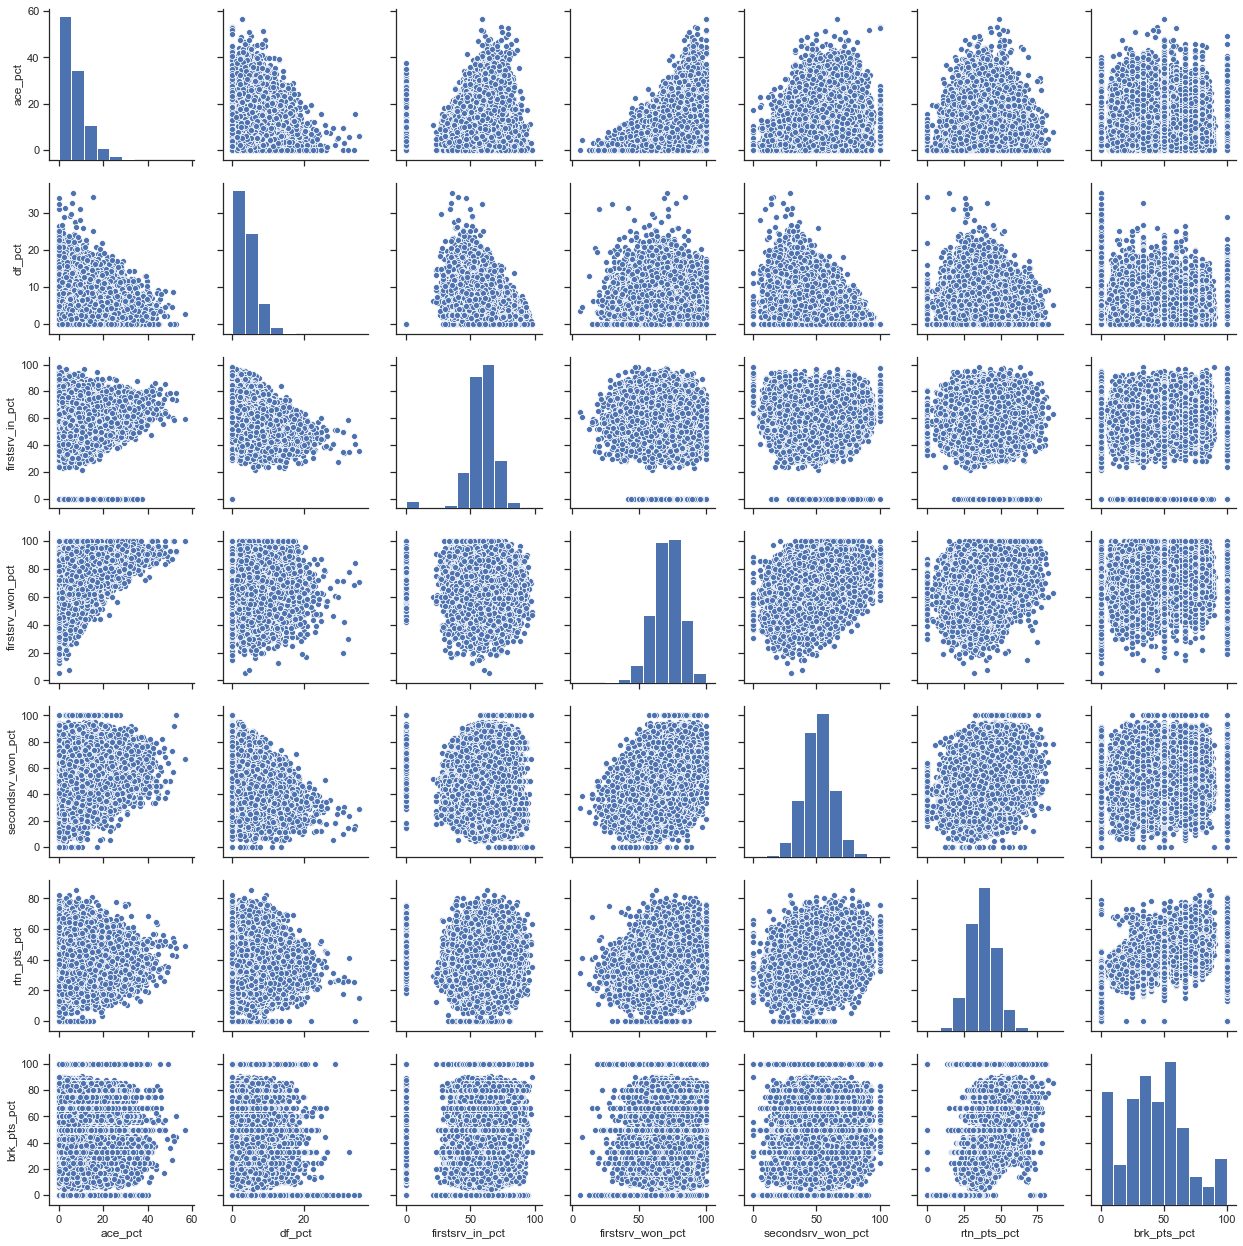

In [8]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(features)
plt.show()

# Logistic Regression

In [9]:
lr = LogisticRegression()

scores = cross_val_score(lr, tr_features, tr_labels.values.ravel(), cv=5)
scores

array([0.92782239, 0.92337853, 0.92483938, 0.92446145, 0.9249811 ])

LR Scores:  [0.9274445  0.92333129 0.92488662 0.9247449  0.92493386]
Mean ROC AUC Score: 0.9250682329905502
LR Score Range: 0.0041


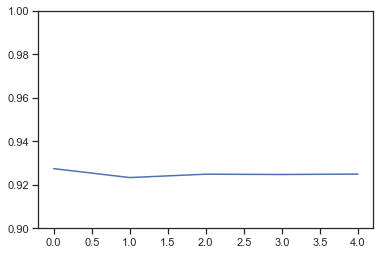

In [10]:
def run_lr(X_train,y_train):
    """
    Run a Logistic Recression of Features and Target Variable. We're using ROC AUC Score with Cross Validation
    """

    lr = LogisticRegression(solver='lbfgs')
    
    lr_scores = cross_val_score(lr, X_train, y_train.values.ravel(), cv=5)
    
    print('LR Scores: ', lr_scores)
    print('Mean ROC AUC Score: {}'.format(lr_scores.mean()))
    print('LR Score Range: {}'.format(round(lr_scores.max() - lr_scores.min(),4)))
    _ = plt.plot(np.arange(len(lr_scores)),lr_scores)
    _ = plt.ylim(0.90,1)
    return lr

lr = run_lr(tr_features,tr_labels)

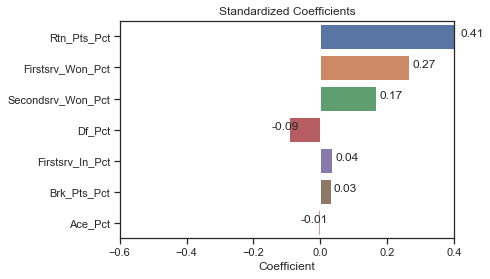

In [11]:
def plot_coef(X,y,features):
    """
    Plot the Beta values of a Logistic Regression based on the Features and Target Variable provided.
    """
    lr = LogisticRegression(solver='lbfgs')
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    lr.fit(X_train,y_train)
    std_coef = lr.coef_.reshape(-1,1).tolist()
    feature_names = [feature.title() for feature in features]
    coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
    coef_df['abs'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
    ax = sns.barplot(coef_df['coef'],coef_df.index)
    for i, row in enumerate(coef_df.iterrows()):
        row_values = row[1]
        if row_values.coef < 0:
            ax.text(row_values.coef - 0.05,i,round(row_values.coef,2))
        else:
            ax.text(row_values.coef + 0.01,i,round(row_values.coef,2))
    _ = plt.xlabel('Coefficient')
    _ = plt.title('Standardized Coefficients')
    _ = plt.xlim(-0.6,0.4)

plot_coef(tr_features,tr_labels,features)

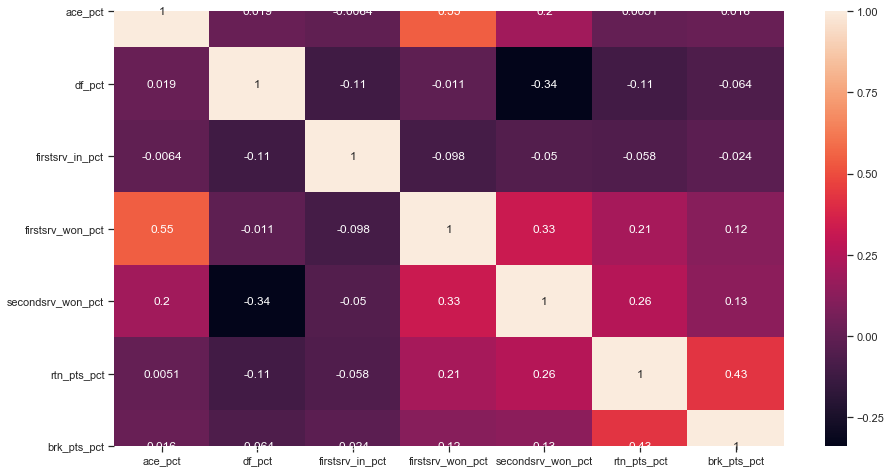

In [12]:
# find correlations to target
corr_matrix = tr_features.corr()

# Plot correlations for Tuning variables
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix,annot=True)
plt.show;

In [13]:
tr_features_new = tr_features.drop(['ace_pct','brk_pts_pct'], axis=1)
tr_features_new.head()

,df_pct,firstsrv_in_pct,firstsrv_won_pct,secondsrv_won_pct,rtn_pts_pct
91745,1.818182,56.363636,83.870968,33.333333,29.230769
50783,8.333333,54.166667,74.358974,48.484848,23.809524
172853,0.000000,52.272727,52.173913,57.142857,40.625000
89657,1.694915,62.711864,59.459459,40.909091,27.083333
65329,4.285714,51.428571,58.333333,41.176471,38.888889


In [14]:
lr = LogisticRegression()

scores = cross_val_score(lr, tr_features_new, tr_labels.values.ravel(), cv=5)
scores

array([0.92158715, 0.91955218, 0.91983182, 0.9191232 , 0.92205215])

LR Scores:  [0.92116202 0.91865464 0.91997354 0.91917045 0.92195767]
Mean ROC AUC Score: 0.9201836642226006
LR Score Range: 0.0033


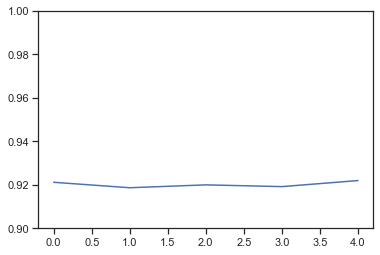

In [15]:
lr = run_lr(tr_features_new,tr_labels)

# Random Forest

## Fit and evaluate a basic model using 5-fold Cross-Validation

In [16]:
rf = RandomForestClassifier()

scores = cross_val_score(rf, tr_features, tr_labels.values.ravel(), cv=5)
scores

array([0.92857818, 0.9220086 , 0.92460317, 0.92384732, 0.92455593])

## Hyperparameter tuning

In [17]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [18]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 100}

0.862 (+/-0.021) for {'max_depth': 2, 'n_estimators': 5}
0.883 (+/-0.01) for {'max_depth': 2, 'n_estimators': 50}
0.892 (+/-0.007) for {'max_depth': 2, 'n_estimators': 100}
0.923 (+/-0.002) for {'max_depth': 10, 'n_estimators': 5}
0.929 (+/-0.003) for {'max_depth': 10, 'n_estimators': 50}
0.93 (+/-0.004) for {'max_depth': 10, 'n_estimators': 100}
0.921 (+/-0.004) for {'max_depth': 20, 'n_estimators': 5}
0.93 (+/-0.003) for {'max_depth': 20, 'n_estimators': 50}
0.931 (+/-0.004) for {'max_depth': 20, 'n_estimators': 100}
0.919 (+/-0.004) for {'max_depth': None, 'n_estimators': 5}
0.931 (+/-0.002) for {'max_depth': None, 'n_estimators': 50}
0.931 (+/-0.004) for {'max_depth': None, 'n_estimators': 100}


## Fit best models on full training set

From above, the top three results came from:<br/>
0.931 (+/-0.003) for {'max_depth': 20, 'n_estimators': 50}<br/>
0.931 (+/-0.002) for {'max_depth': 20, 'n_estimators': 100}<br/>
0.931 (+/-0.004) for {'max_depth': None, 'n_estimators': 100}<br/>

In [19]:
rf1 = RandomForestClassifier(n_estimators=50, max_depth=20)
rf1.fit(tr_features, tr_labels.values.ravel())

rf2 = RandomForestClassifier(n_estimators=100, max_depth=20)
rf2.fit(tr_features, tr_labels.values.ravel())

rf3 = RandomForestClassifier(n_estimators=100, max_depth=None)
rf3.fit(tr_features, tr_labels.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluate models on validation set

In [20]:
for mdl in [rf1, rf2, rf3]:
    y_pred = mdl.predict(val_features)
    accuracy = round(accuracy_score(val_labels, y_pred), 3)
    precision = round(precision_score(val_labels, y_pred), 3)
    recall = round(recall_score(val_labels, y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

MAX DEPTH: 20 / # OF EST: 50 -- A: 0.93 / P: 0.931 / R: 0.93
MAX DEPTH: 20 / # OF EST: 100 -- A: 0.931 / P: 0.932 / R: 0.931
MAX DEPTH: None / # OF EST: 100 -- A: 0.931 / P: 0.932 / R: 0.93


## Evaluate the best model on the test set

In [21]:
y_pred = rf3.predict(te_features)
accuracy = round(accuracy_score(te_labels, y_pred), 3)
precision = round(precision_score(te_labels, y_pred), 3)
recall = round(recall_score(te_labels, y_pred), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf3.max_depth,
                                                                     rf3.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

MAX DEPTH: None / # OF EST: 100 -- A: 0.93 / P: 0.929 / R: 0.93


## Drop some features to reduce overfitting.

In [22]:
tr_features_new = X_train.drop(['ace_pct','brk_pts_pct'], axis=1)
val_features_new = X_val.drop(['ace_pct','brk_pts_pct'], axis=1)
te_features_new = X_test.drop(['ace_pct','brk_pts_pct'], axis=1)

In [23]:
rf = RandomForestClassifier()

scores = cross_val_score(rf, tr_features_new, tr_labels.values.ravel(), cv=5)
scores

array([0.91889466, 0.91681232, 0.918887  , 0.91874528, 0.91832011])

In [24]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(tr_features_new, tr_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 10, 'n_estimators': 100}

0.854 (+/-0.031) for {'max_depth': 2, 'n_estimators': 5}
0.87 (+/-0.009) for {'max_depth': 2, 'n_estimators': 50}
0.89 (+/-0.005) for {'max_depth': 2, 'n_estimators': 100}
0.922 (+/-0.004) for {'max_depth': 10, 'n_estimators': 5}
0.925 (+/-0.002) for {'max_depth': 10, 'n_estimators': 50}
0.925 (+/-0.002) for {'max_depth': 10, 'n_estimators': 100}
0.914 (+/-0.004) for {'max_depth': 20, 'n_estimators': 5}
0.923 (+/-0.003) for {'max_depth': 20, 'n_estimators': 50}
0.923 (+/-0.003) for {'max_depth': 20, 'n_estimators': 100}
0.914 (+/-0.003) for {'max_depth': None, 'n_estimators': 5}
0.923 (+/-0.003) for {'max_depth': None, 'n_estimators': 50}
0.924 (+/-0.003) for {'max_depth': None, 'n_estimators': 100}


## Top three 
0.925 (+/-0.002) for {'max_depth': 10, 'n_estimators': 50}<br/>
0.925 (+/-0.002) for {'max_depth': 10, 'n_estimators': 100}<br/>
0.924 (+/-0.002) for {'max_depth': 20, 'n_estimators': 50}<br/>

In [25]:
rf1 = RandomForestClassifier(n_estimators=50, max_depth=10)
rf1.fit(tr_features_new, tr_labels.values.ravel())

rf2 = RandomForestClassifier(n_estimators=100, max_depth=10)
rf2.fit(tr_features_new, tr_labels.values.ravel())

rf3 = RandomForestClassifier(n_estimators=50, max_depth=20)
rf3.fit(tr_features_new, tr_labels.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
for mdl in [rf1, rf2, rf3]:
    y_pred = mdl.predict(val_features_new)
    accuracy = round(accuracy_score(val_labels, y_pred), 3)
    precision = round(precision_score(val_labels, y_pred), 3)
    recall = round(recall_score(val_labels, y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

MAX DEPTH: 10 / # OF EST: 50 -- A: 0.925 / P: 0.927 / R: 0.923
MAX DEPTH: 10 / # OF EST: 100 -- A: 0.925 / P: 0.927 / R: 0.925
MAX DEPTH: 20 / # OF EST: 50 -- A: 0.923 / P: 0.924 / R: 0.923


## Re-run Final Model

In [27]:
y_pred = rf2.predict(te_features_new)
accuracy = round(accuracy_score(te_labels, y_pred), 3)
precision = round(precision_score(te_labels, y_pred), 3)
recall = round(recall_score(te_labels, y_pred), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf2.max_depth,
                                                                     rf2.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

MAX DEPTH: 10 / # OF EST: 100 -- A: 0.925 / P: 0.923 / R: 0.925
